In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import seaborn as sns
from statsmodels.tsa.seasonal import STL

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
rider = pd.read_csv('AmtrakBig_CA_Question-3.csv',
                    parse_dates=['Month'], 
                    index_col='Month',
                    date_parser=dateparse)
rider.head()

,Ridership,t,Season
Month,,,
2005-01-01,1709,1,Jan
2005-02-01,1621,2,Feb
2005-03-01,1973,3,Mar
2005-04-01,1812,4,Apr
2005-05-01,1975,5,May


In [5]:
cols = ['t','Season']
rider_ts = rider.drop(cols, axis = 1)
rider_ts.head()

,Ridership
Month,
2005-01-01,1709
2005-02-01,1621
2005-03-01,1973
2005-04-01,1812
2005-05-01,1975


In [4]:
len(rider_ts)

159

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


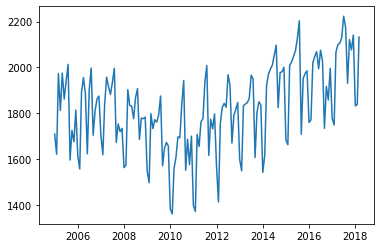

In [5]:
plt.plot(rider_ts)

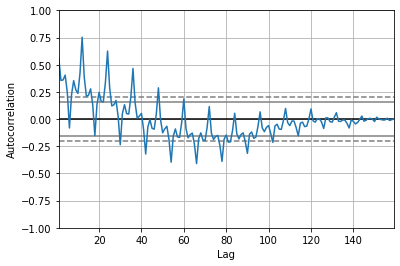

<Figure size 7200x3600 with 0 Axes>

In [6]:
autocorrelation_plot(rider_ts)
plt.figure(figsize=(100,50))
plt.show()

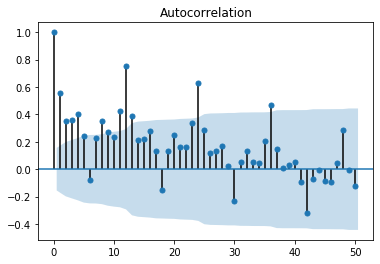

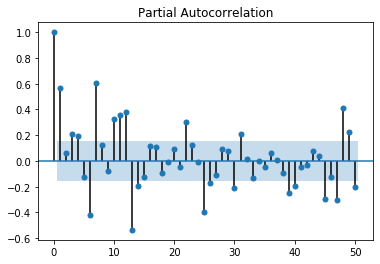

In [7]:
# ACF
plot_acf(rider_ts, lags=50)
plt.show()

# PACF
plot_pacf(rider_ts, lags=50)
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    timeseries = timeseries.iloc[:,0].values
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

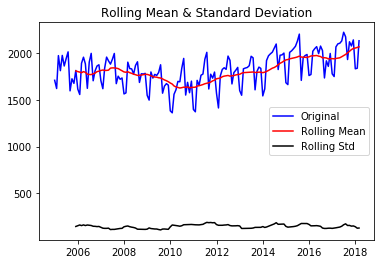

Results of Dickey-Fuller Test:
Test Statistic                  -0.234991
p-value                          0.934220
#Lags Used                      14.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [9]:
test_stationarity(rider_ts)

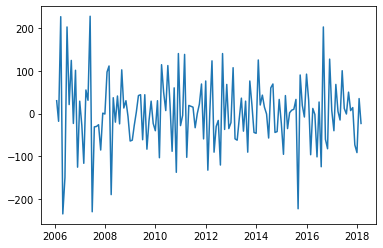

In [10]:
# Differencing 1
# lag 12
rider_diff = rider_ts - rider_ts.shift()
rider_diff_1 = rider_diff - rider_diff.shift(12)
plt.plot(rider_diff_1)

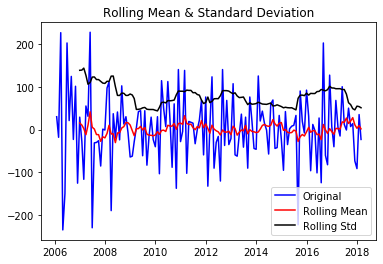

Results of Dickey-Fuller Test:
Test Statistic                  -4.992382
p-value                          0.000023
#Lags Used                      12.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [11]:
test_stationarity(rider_diff_1.dropna())

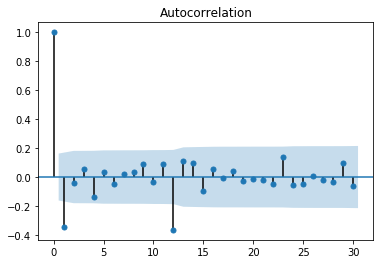

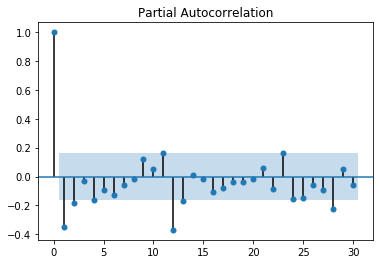

In [12]:
# d = 1
# ACF
plot_acf(rider_diff_1.dropna(), lags=30)
plt.show()

# PACF
plot_pacf(rider_diff_1.dropna(), lags=30)
plt.show()

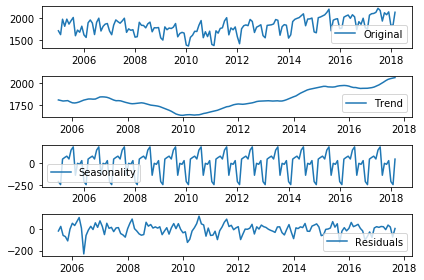

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(rider_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(rider_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

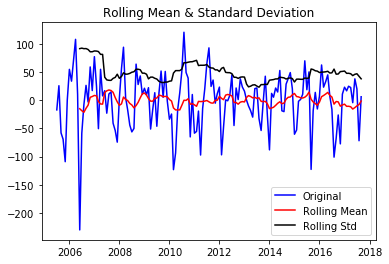

Results of Dickey-Fuller Test:
Test Statistic                -6.649005e+00
p-value                        5.177733e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.370000e+02
Critical Value (1%)           -3.479007e+00
Critical Value (5%)           -2.882878e+00
Critical Value (10%)          -2.578149e+00
dtype: float64


In [14]:
# check stationarity of residuals
rider_decompose = residual
rider_decompose.dropna(inplace=True)
test_stationarity(rider_decompose)

In [15]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(rider_diff_1.dropna(), nlags=50)
lag_pacf = pacf(rider_diff_1.dropna(), nlags=50, method='ols')

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


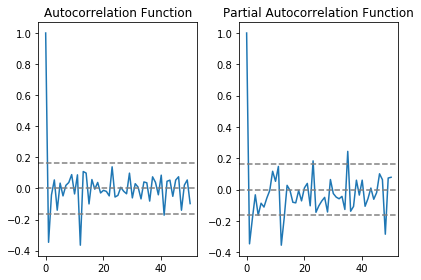

In [16]:
# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [17]:
# 1,1,1 ARIMA Model
model111 = ARIMA(rider_ts, order=(1,1,1))
model_fit111 = model111.fit(disp=0)
print(model_fit111.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Ridership   No. Observations:                  158
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1009.391
Method:                       css-mle   S.D. of innovations            143.387
Date:                Sat, 21 Sep 2019   AIC                           2026.782
Time:                        15:44:56   BIC                           2039.033
Sample:                    02-01-2005   HQIC                          2031.758
                         - 03-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.5669      1.425      1.100      0.273      -1.225       4.359
ar.L1.D.Ridership     0.3517      0.083      4.227      0.000       0.189       0.515
ma.L1.D.Ridership    -0.

In [18]:
# 1,2,1 ARIMA Model
model121 = ARIMA(rider_ts, order=(1,2,1))
model_fit121 = model121.fit(disp=0)
print(model_fit121.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  157
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1025.396
Method:                       css-mle   S.D. of innovations            163.118
Date:                Sat, 21 Sep 2019   AIC                           2058.793
Time:                        15:44:58   BIC                           2071.018
Sample:                    03-01-2005   HQIC                          2063.758
                         - 03-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0291      0.228      0.128      0.898      -0.417       0.475
ar.L1.D2.Ridership    -0.2552      0.078     -3.282      0.001      -0.408      -0.103
ma.L1.D2.Ridership  

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
# 2,2,1 ARIMA Model
model221 = ARIMA(rider_ts, order=(2,2,1))
model_fit221 = model221.fit(disp=0)
print(model_fit221.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  157
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1016.823
Method:                       css-mle   S.D. of innovations            154.059
Date:                Sat, 21 Sep 2019   AIC                           2043.646
Time:                        15:45:00   BIC                           2058.927
Sample:                    03-01-2005   HQIC                          2049.852
                         - 03-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0275      0.163      0.169      0.866      -0.292       0.347
ar.L1.D2.Ridership    -0.3410      0.076     -4.479      0.000      -0.490      -0.192
ar.L2.D2.Ridership  

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


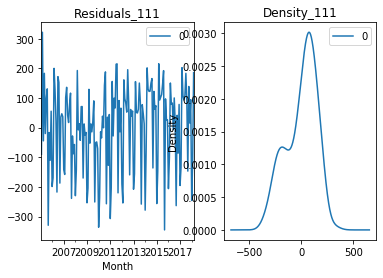

In [20]:
# Plot residual errors - Model111
residuals111 = pd.DataFrame(model_fit111.resid)
fig, ax = plt.subplots(1,2)
residuals111.plot(title="Residuals_111", ax=ax[0])
residuals111.plot(kind='kde', title='Density_111', ax=ax[1])
plt.show()

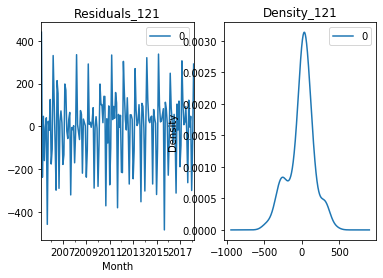

In [21]:
# Plot residual errors - Model121
residuals121 = pd.DataFrame(model_fit121.resid)
fig, ax = plt.subplots(1,2)
residuals121.plot(title="Residuals_121", ax=ax[0])
residuals121.plot(kind='kde', title='Density_121', ax=ax[1])
plt.show()

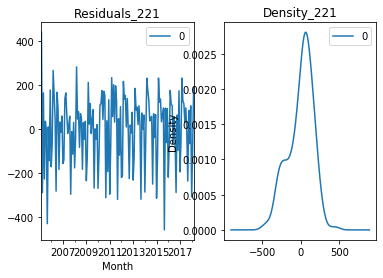

In [22]:
# Plot residual errors - Model221
residuals221 = pd.DataFrame(model_fit221.resid)
fig, ax = plt.subplots(1,2)
residuals221.plot(title="Residuals_221", ax=ax[0])
residuals221.plot(kind='kde', title='Density_221', ax=ax[1])
plt.show()

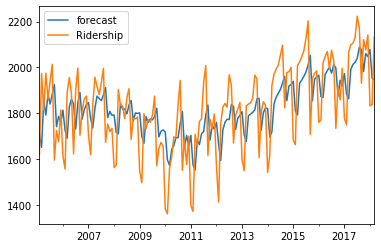

In [23]:
# Actual vs Fitted
model_fit111.plot_predict(dynamic=False)
plt.show()

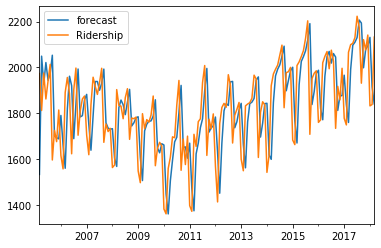

In [24]:
model_fit121.plot_predict(dynamic=False)
plt.show()

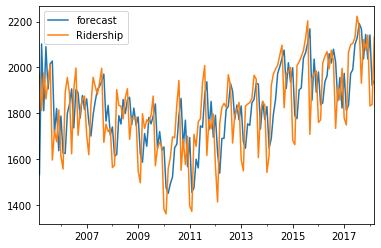

In [25]:
model_fit221.plot_predict(dynamic=False)
plt.show()

In [26]:
train = rider_ts[:132]
test = rider_ts[132:]

In [27]:
len(train)

132

In [28]:
len(test)

27

In [12]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    data = {'Metrics':[mape,me,mae,mpe,rmse]}
    accuracy = pd.DataFrame(data, index = ['MAPE','ME','MAE','MPE','RMSE'])
    print(accuracy)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Ridership   No. Observations:                  131
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.048
Method:                       css-mle   S.D. of innovations            144.568
Date:                Sat, 21 Sep 2019   AIC                           1684.096
Time:                        15:47:17   BIC                           1695.596
Sample:                    02-01-2005   HQIC                          1688.769
                         - 12-01-2015                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3076      1.734      0.754      0.452      -2.092       4.707
ar.L1.D.Ridership     0.3489      0.093      3.769      0.000       0.167       0.530
ma.L1.D.Ridership    -0.

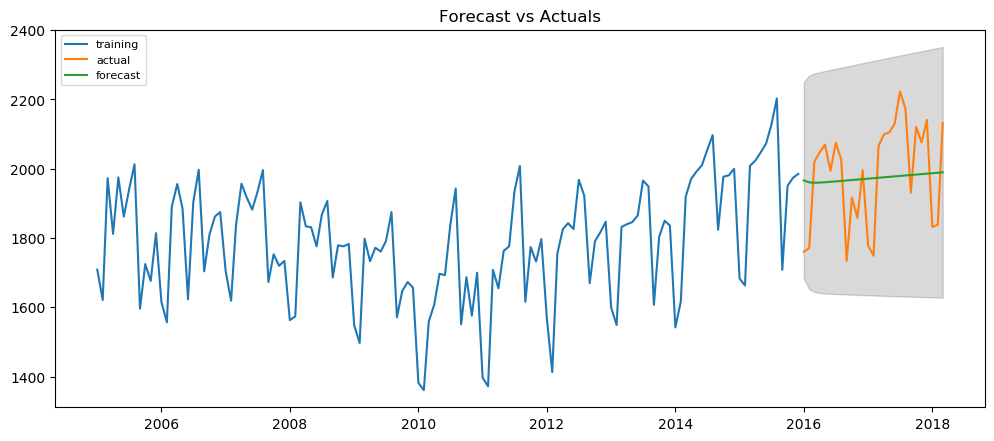

          Merics
MAPE    0.066522
ME    -14.251097
MAE   130.180326
MPE    -0.001662
RMSE  146.152142


In [30]:
# 1,1,1 ARIMA Model
model_train = ARIMA(train, order=(1, 1, 1))  
fitted = model_train.fit(disp=-1)  
print(fitted.summary())

fc, se, conf = fitted.forecast(27, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  130
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -850.219
Method:                       css-mle   S.D. of innovations            164.101
Date:                Sat, 21 Sep 2019   AIC                           1708.438
Time:                        15:47:20   BIC                           1719.909
Sample:                    03-01-2005   HQIC                          1713.099
                         - 12-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0345      0.303      0.114      0.910      -0.559       0.628
ar.L1.D2.Ridership    -0.2569      0.085     -3.040      0.003      -0.423      -0.091
ma.L1.D2.Ridership  

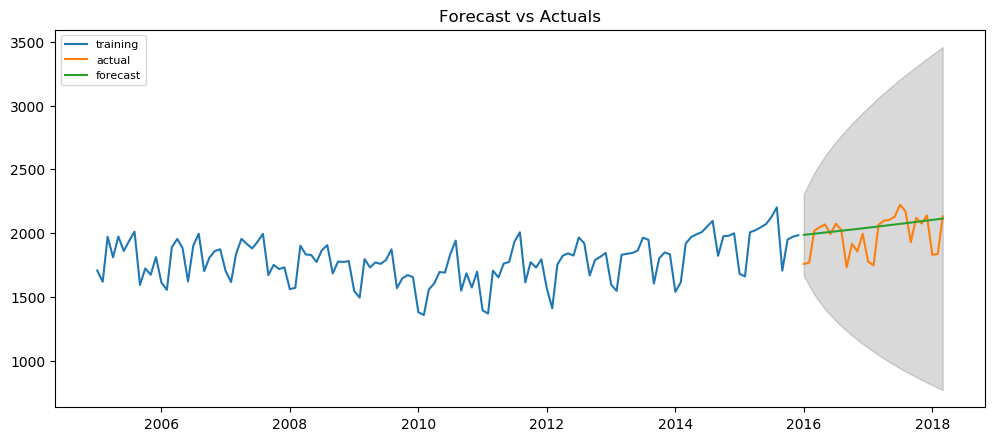

          Merics
MAPE    0.067325
ME     62.466060
MAE   127.034202
MPE     0.037151
RMSE  162.587203


In [31]:
# 1,2,1 ARIMA Model
model_train = ARIMA(train, order=(1, 2, 1))  
fitted = model_train.fit(disp=-1)  
print(fitted.summary())
fc, se, conf = fitted.forecast(27, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  130
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -843.391
Method:                       css-mle   S.D. of innovations            155.240
Date:                Sat, 21 Sep 2019   AIC                           1696.781
Time:                        15:47:24   BIC                           1711.119
Sample:                    03-01-2005   HQIC                          1702.607
                         - 12-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0509      0.219      0.232      0.817      -0.378       0.480
ar.L1.D2.Ridership    -0.3412      0.083     -4.113      0.000      -0.504      -0.179
ar.L2.D2.Ridership  

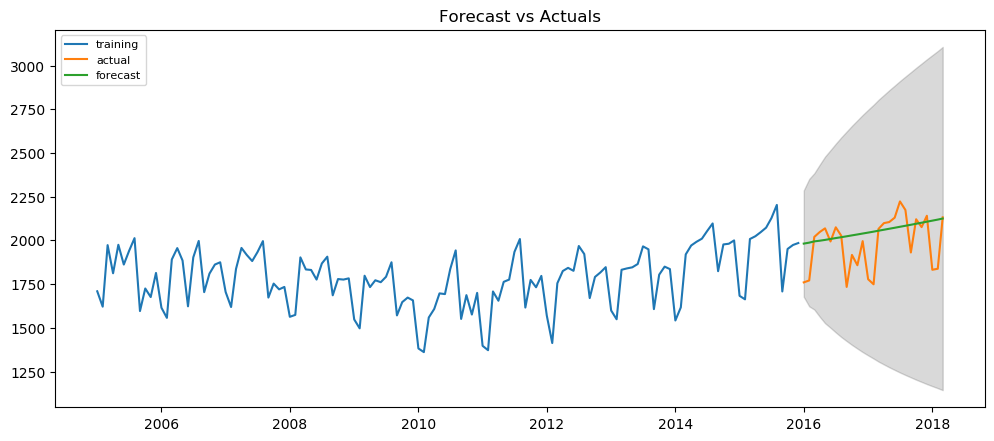

          Merics
MAPE    0.068021
ME     64.050427
MAE   128.365480
MPE     0.037953
RMSE  164.259985


In [32]:
# 2,2,1 ARIMA Model
model_train = ARIMA(train, order=(2, 2, 1))  
fitted = model_train.fit(disp=-1) 
print(fitted.summary())
fc, se, conf = fitted.forecast(27, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 1, 1); AIC=1684.096, BIC=1695.596, Fit time=0.218 seconds
Fit ARIMA: order=(0, 1, 0); AIC=1720.563, BIC=1726.313, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1713.153, BIC=1721.778, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1695.941, BIC=1704.566, Fit time=0.042 seconds
Fit ARIMA: order=(2, 1, 1); AIC=1684.934, BIC=1699.310, Fit time=0.154 seconds
Fit ARIMA: order=(1, 1, 2); AIC=1685.409, BIC=1699.785, Fit time=0.141 seconds
Fit ARIMA: order=(2, 1, 2); AIC=1658.796, BIC=1676.048, Fit time=0.405 seconds
Fit ARIMA: order=(3, 1, 2); AIC=1633.317, BIC=1653.443, Fit time=0.829 seconds
Fit ARIMA: order=(3, 1, 1); AIC=1695.135, BIC=1712.386, Fit time=0.144 seconds
Fit ARIMA: order=(3, 1, 3); AIC=1637.876, BIC=1660.878, Fit time=1.465 seconds
Total fit time: 3.472 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                

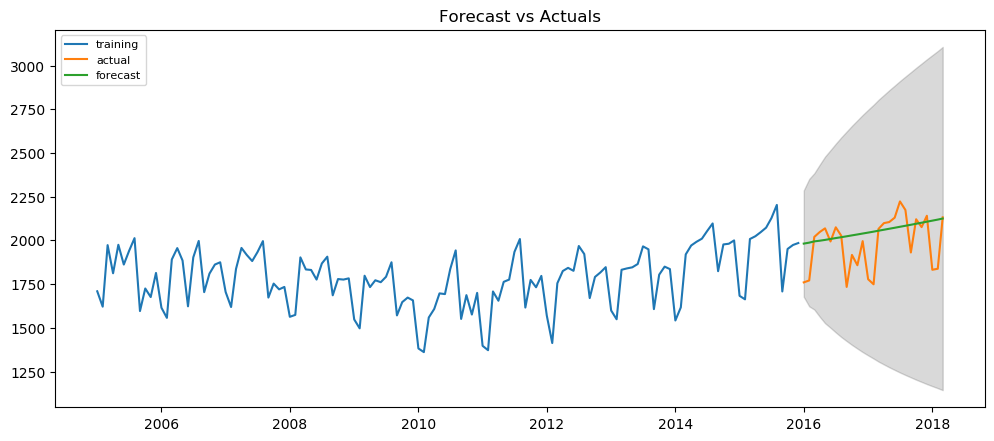

          Merics
MAPE    0.068021
ME     64.050427
MAE   128.365480
MPE     0.037953
RMSE  164.259985


In [33]:
# AUTO ARIMA
# d = 1
model_auto = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,          
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto.summary())

fc, se, conf = fitted.forecast(27, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 2, 1); AIC=1708.438, BIC=1719.909, Fit time=0.275 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1828.903, BIC=1834.638, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1791.046, BIC=1799.649, Fit time=0.042 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1715.319, BIC=1723.922, Fit time=0.080 seconds
Fit ARIMA: order=(2, 2, 1); AIC=1696.781, BIC=1711.119, Fit time=0.130 seconds
Fit ARIMA: order=(2, 2, 0); AIC=1766.235, BIC=1777.705, Fit time=0.095 seconds
Fit ARIMA: order=(2, 2, 2); AIC=1678.868, BIC=1696.073, Fit time=0.593 seconds
Fit ARIMA: order=(3, 2, 3); AIC=1635.870, BIC=1658.811, Fit time=1.212 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 2); AIC=1691.546, BIC=1711.619, Fit time=0.428 seconds
Total fit time: 2.880 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  130
Model:                 ARIMA(3, 2,

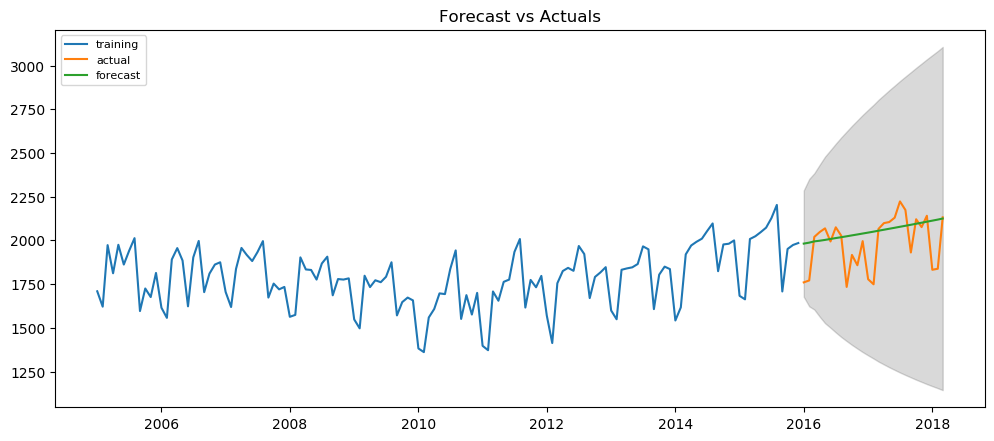

          Merics
MAPE    0.068021
ME     64.050427
MAE   128.365480
MPE     0.037953
RMSE  164.259985


In [34]:
# AUTO ARIMA
# d = 2
model_auto = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,          
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto.summary())

fc, se, conf = fitted.forecast(27, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1338.478, BIC=1352.373, Fit time=0.608 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1392.475, BIC=1398.033, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1358.428, BIC=1369.544, Fit time=0.293 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1339.688, BIC=1350.805, Fit time=0.441 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1340.132, BIC=1356.807, Fit time=1.168 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1372.293, BIC=1383.409, Fit time=0.287 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1340.126, BIC=1356.801, Fit time=1.911 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1341.315, BIC=1360.769, Fit time=3.714 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1339.185, BIC=1355.860, Fit time=1.853 seconds
Fit ARIMA: order=(1, 1, 0) s

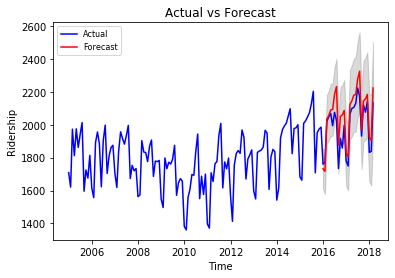

         Metrics
MAPE    0.095007
ME     70.789750
MAE   183.028717
MPE     0.041362
RMSE  227.614004


In [78]:
# Seasonal - fit stepwise auto-ARIMA
# d = 1
smodel = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,             # frequency of series
                      d=1,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel.summary())

# Forecast
n_periods = 27
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

forecast_accuracy(fitted, test.values)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1343.950, BIC=1357.804, Fit time=0.485 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1498.665, BIC=1504.207, Fit time=0.024 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1427.098, BIC=1438.181, Fit time=0.316 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1356.783, BIC=1367.866, Fit time=0.304 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=1345.812, BIC=1362.437, Fit time=0.582 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1375.917, BIC=1387.000, Fit time=0.153 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=1345.807, BIC=1362.432, Fit time=1.248 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=1347.267, BIC=1366.661, Fit time=2.868 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1343.197, BIC=1359.821, Fit time=0.517 seconds
Fit ARIMA: order=(2, 2, 0) s

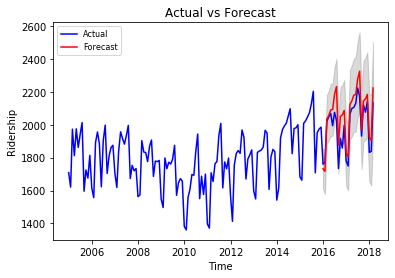

          Merics
MAPE    0.095007
ME     70.789750
MAE   183.028717
MPE     0.041362
RMSE  227.614004


In [36]:
# Seasonal - fit stepwise auto-ARIMA
# d = 2
model_auto = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto.summary())

# Forecast
n_periods = 27
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

forecast_accuracy(fitted, test.values)

In [37]:
# Fitting ARIMA: d = 1
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2295      0.174      1.316      0.188      -0.112       0.571
ma.L1         -0.6781      0.136     -4.972      0.000      -0.945      -0.411
ma.S.L12      -0.6352      0.098     -6.471      0.000      -0.828      -0.443
sigma2      3229.8285    462.029      6.991      0.000    2324.269    4135.388


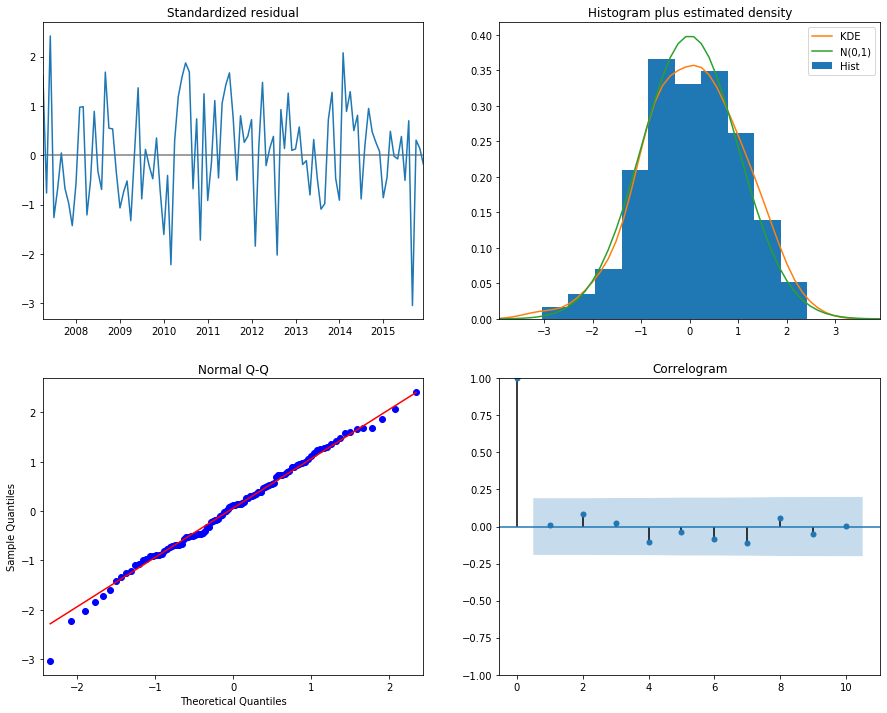

In [38]:
# residual plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [39]:
sm.stats.acorr_ljungbox(results.resid, lags=[12])

(array([60.94576217]), array([1.51689543e-08]))

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1627.802, BIC=1642.720, Fit time=1.050 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1701.905, BIC=1707.873, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1656.951, BIC=1668.885, Fit time=0.371 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1629.323, BIC=1641.258, Fit time=0.352 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1629.360, BIC=1647.261, Fit time=0.789 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1678.181, BIC=1690.115, Fit time=0.196 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1629.290, BIC=1647.191, Fit time=1.539 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1631.612, BIC=1652.497, Fit time=3.469 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1628.066, BIC=1645.968, Fit time=1.376 seconds
Fit ARIMA: order=(1, 1, 0) s

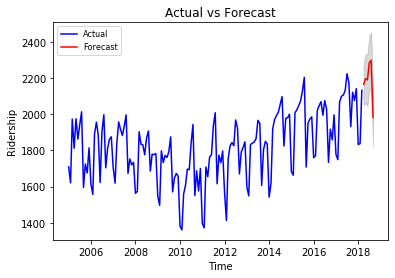

2018-04-01    2165.0
2018-05-01    2196.0
2018-06-01    2189.0
2018-07-01    2284.0
2018-08-01    2298.0
2018-09-01    1982.0
Freq: MS, dtype: float64


In [59]:
# Final Model
# d = 1
final_model = pm.auto_arima(rider_ts.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=1,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(final_model.summary())

# Forecast
n_periods = 6
fitted, confint = final_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(rider_ts.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(np.round(fitted), index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

print(fitted_series)

In [41]:
train_ets = train.astype("double")
rider_ets = rider_ts.astype("double")

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


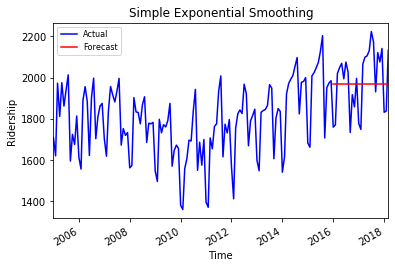

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1513171                alpha                 True
initial_level              1801.4502                  l.0                 True
------------------------------------------------------------------------------


In [42]:
# simple exponential smoothing
fit = SimpleExpSmoothing(train_ets).fit()
fcast = fit.forecast(27).rename(r'$\alpha=%s$'%fit.model.params['smoothing_level'])
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Simple Exponential Smoothing")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


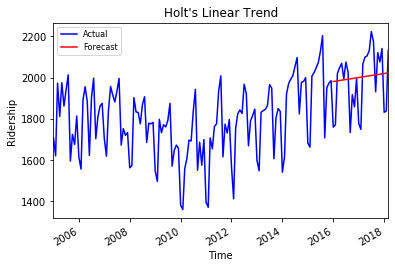

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8000000                alpha                False
smoothing_slope            0.2000000                 beta                False
initial_level              1709.0000                  l.0                False
initial_slope             -88.000000                  b.0                False
------------------------------------------------------------------------------


In [43]:
# Holt's linear trend
fit = Holt(train_ets).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast = fit.forecast(27).rename("Holt's linear trend")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Holt's Linear Trend")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


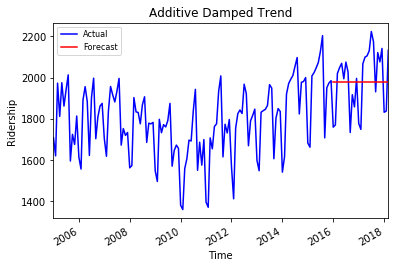

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8000000                alpha                False
smoothing_slope            0.2000000                 beta                False
initial_level              1704.4306                  l.0                 True
initial_slope               0.000000                  b.0                 True
damping_slope               0.000000                  phi                 True
------------------------------------------------------------------------------


In [44]:
# Additive damped trend
fit = Holt(train_ets, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast = fit.forecast(27).rename("Additive damped trend")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Additive Damped Trend")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


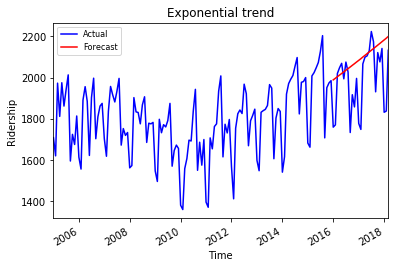

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8000000                alpha                False
smoothing_slope            0.2000000                 beta                False
initial_level              1709.0000                  l.0                False
initial_slope              0.9485079                  b.0                False
------------------------------------------------------------------------------


In [45]:
# Exponential trend
fit = Holt(train_ets, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast = fit.forecast(27).rename("Exponential trend")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Exponential trend")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])

In [75]:
# Accuracy metrics
def ets_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)).values  # MAPE
    me = np.mean(forecast - actual).values             # ME
    mae = np.mean(np.abs(forecast - actual)).values    # MAE
    mpe = np.mean((forecast - actual)/actual).values   # MPE
    rmse = (np.mean((forecast - actual)**2)**.5).values  # RMSE
    data = {'Metrics':[mape,me,mae,mpe,rmse]}
    accuracy = pd.DataFrame(data, index = ['MAPE','ME','MAE','MPE','RMSE'])
    print(accuracy)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


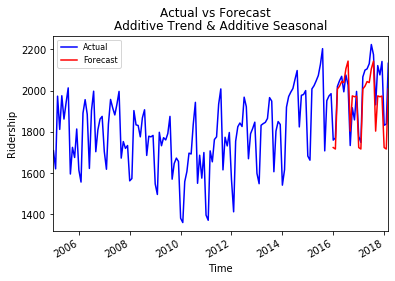

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4261242                alpha                 True
smoothing_slope              1.2675e-09                 beta                 True
smoothing_seasonal            0.2310106                gamma                 True
initial_level                1.5653e+06                  l.0                 True
initial_slope                9.7021e-05                  b.0                 True
initial_seasons.0            1.1419e+05                  s.0                 True
initial_seasons.1            -5487.6737                  s.1                 True
initial_seasons.2            6.5112e+05                  s.2                 True
initial_seasons.3            6.0639e+05                  s.3                 True
initial_seasons.4            6.9066e+05                  s.4                 True
initial_seasons.

In [47]:
# additive trend, additive seasonal
fit = ExponentialSmoothing(train_ets, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fcast = fit.forecast(27).rename("Additive Trend & Additive Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Additive Trend & Additive Seasonal")
plt.suptitle("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])
ets_accuracy(pd.DataFrame(fcast), test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


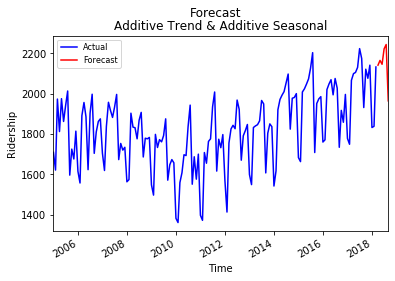

2018-04-01    2140.954793
2018-05-01    2164.515866
2018-06-01    2145.357515
2018-07-01    2221.655464
2018-08-01    2243.367767
2018-09-01    1964.185071
Freq: MS, Name: Additive Trend & Additive Seasonal, dtype: float64

In [48]:
# Forecast
# additive trend, additive seasonal
fit = ExponentialSmoothing(rider_ets, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fcast = fit.forecast(6).rename("Additive Trend & Additive Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Additive Trend & Additive Seasonal")
plt.suptitle("Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
fcast

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


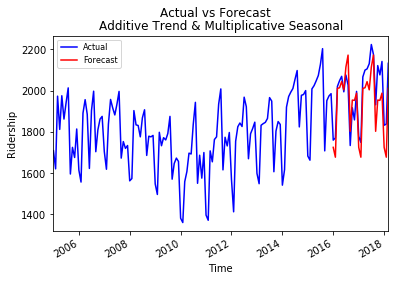

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5669126                alpha                 True
smoothing_slope              2.3687e-10                 beta                 True
smoothing_seasonal           7.9001e-09                gamma                 True
initial_level                1.4432e+06                  l.0                 True
initial_slope                1.0185e-05                  b.0                 True
initial_seasons.0             1.1409646                  s.0                 True
initial_seasons.1             1.0781071                  s.1                 True
initial_seasons.2             1.5551325                  s.2                 True
initial_seasons.3             1.5595154                  s.3                 True
initial_seasons.4             1.6065022                  s.4                 True
initial_seasons.

In [49]:
# additive trend, multiplicative seasonal
fit = ExponentialSmoothing(train_ets, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fcast = fit.forecast(27).rename("Additive Trend & Multiplicative Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Additive Trend & Multiplicative Seasonal")
plt.suptitle("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])
ets_accuracy(pd.DataFrame(fcast), test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


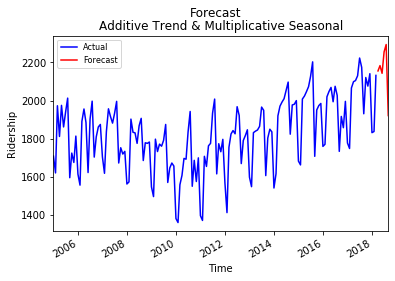

2018-04-01    2155.447368
2018-05-01    2183.350209
2018-06-01    2142.948841
2018-07-01    2255.310413
2018-08-01    2293.859176
2018-09-01    1921.519592
Freq: MS, Name: Additive Trend & Multiplicative Seasonal, dtype: float64

In [50]:
# Forecast
# additive trend, multiplicative seasonal
fit = ExponentialSmoothing(rider_ets, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fcast = fit.forecast(6).rename("Additive Trend & Multiplicative Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Additive Trend & Multiplicative Seasonal")
plt.suptitle("Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
fcast

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


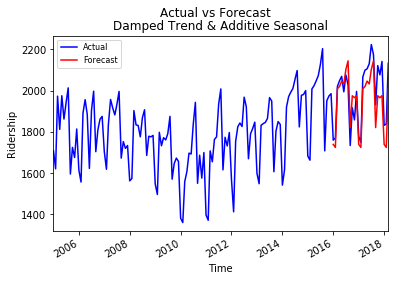

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4568800                alpha                 True
smoothing_slope                5.81e-06                 beta                 True
smoothing_seasonal            0.1680396                gamma                 True
initial_level                1.6156e+06                  l.0                 True
initial_slope                3.8793e-08                  b.0                 True
damping_slope                 0.0551141                  phi                 True
initial_seasons.0             69901.493                  s.0                 True
initial_seasons.1            -23643.398                  s.1                 True
initial_seasons.2            6.1868e+05                  s.2                 True
initial_seasons.3            6.1235e+05                  s.3                 True
initial_seasons.

In [67]:
# damped trend, additive seasonal 
fit = ExponentialSmoothing(train_ets, seasonal_periods=12, trend='add', seasonal='add',damped=True).fit(use_boxcox=True)
fcast = fit.forecast(27).rename("Damped Trend & Additive Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Damped Trend & Additive Seasonal")
plt.suptitle("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])
ets_accuracy(pd.DataFrame(fcast), test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


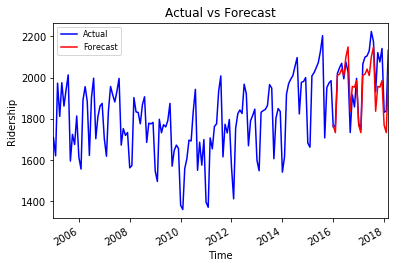

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5072377                alpha                 True
smoothing_seasonal             0.000000                gamma                 True
initial_level                1.5864e+06                  l.0                 True
initial_seasons.0             73069.968                  s.0                 True
initial_seasons.1             276.34718                  s.1                 True
initial_seasons.2            6.1258e+05                  s.2                 True
initial_seasons.3             6.253e+05                  s.3                 True
initial_seasons.4            6.8362e+05                  s.4                 True
initial_seasons.5            6.0958e+05                  s.5                 True
initial_seasons.6            8.2711e+05                  s.6                 True
initial_seasons.

In [80]:
# none trend, additive seasonal 
fit = ExponentialSmoothing(train_ets, seasonal_periods=12, seasonal='add').fit(use_boxcox=True)
fcast = fit.forecast(27).rename("None Trend & Additive Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])
ets_accuracy(pd.DataFrame(fcast), test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


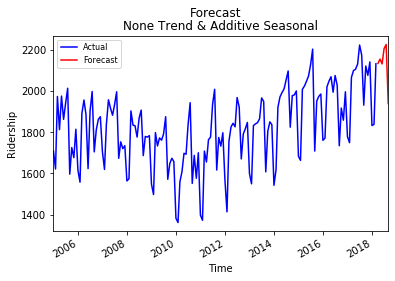

2018-04-01    2134.0
2018-05-01    2155.0
2018-06-01    2131.0
2018-07-01    2206.0
2018-08-01    2225.0
2018-09-01    1938.0
Freq: MS, Name: None Trend & Additive Seasonal, dtype: float64

In [79]:
# Forecast
# damped trend, additive seasonal 
fit = ExponentialSmoothing(rider_ets, seasonal_periods=12, seasonal='add').fit(use_boxcox=True)
fcast = fit.forecast(6).rename("None Trend & Additive Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("None Trend & Additive Seasonal")
plt.suptitle("Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
np.round(fcast)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


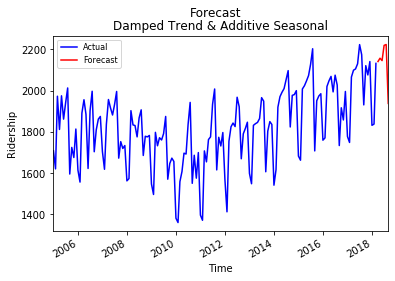

2018-04-01    2141.057620
2018-05-01    2157.078374
2018-06-01    2145.577276
2018-07-01    2219.374095
2018-08-01    2223.458193
2018-09-01    1938.160350
Freq: MS, Name: Damped Trend & Additive Seasonal, dtype: float64

In [52]:
# Forecast
# damped trend, additive seasonal 
fit = ExponentialSmoothing(rider_ets, seasonal_periods=12, trend='add', seasonal='add',damped=True).fit(use_boxcox=True)
fcast = fit.forecast(6).rename("Damped Trend & Additive Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Damped Trend & Additive Seasonal")
plt.suptitle("Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
fcast

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


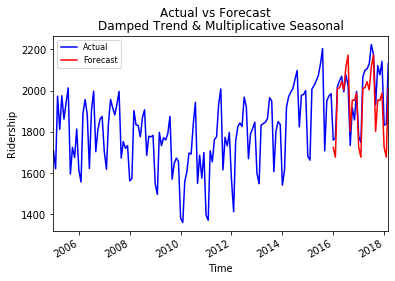

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5668580                alpha                 True
smoothing_slope               0.0524411                 beta                 True
smoothing_seasonal             0.000000                gamma                 True
initial_level                1.4432e+06                  l.0                 True
initial_slope                  0.000000                  b.0                 True
damping_slope                 0.0033276                  phi                 True
initial_seasons.0             1.1409317                  s.0                 True
initial_seasons.1             1.0780749                  s.1                 True
initial_seasons.2             1.5550868                  s.2                 True
initial_seasons.3             1.5594685                  s.3                 True
initial_seasons.

In [53]:
# damped trend, multiplicative seasonal
fit = ExponentialSmoothing(train_ets, seasonal_periods=12, trend='add', seasonal='mul',damped=True).fit(use_boxcox=True)
fcast = fit.forecast(27).rename("Damped Trend & Multiplicative Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Damped Trend & Multiplicative Seasonal")
plt.suptitle("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
print(fit.summary().tables[1])
ets_accuracy(pd.DataFrame(fcast), test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


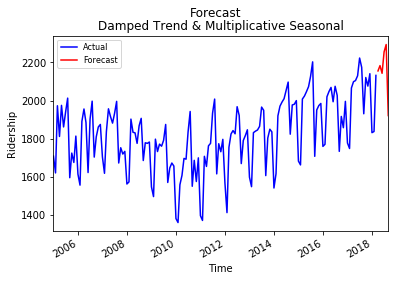

2018-04-01    2155.449276
2018-05-01    2183.351667
2018-06-01    2142.950053
2018-07-01    2255.314335
2018-08-01    2293.863299
2018-09-01    1921.522238
Freq: MS, Name: Damped Trend & Multiplicative Seasonal, dtype: float64

In [54]:
# Forecast
# damped trend, multiplicative seasonal
fit = ExponentialSmoothing(rider_ets, seasonal_periods=12, trend='add', seasonal='mul',damped=True).fit(use_boxcox=True)
fcast = fit.forecast(6).rename("Damped Trend & Multiplicative Seasonal")
# plot
plt.plot(rider_ts, color='blue', label='Actual')
fcast.plot(color='red', legend=False, label = 'Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title("Damped Trend & Multiplicative Seasonal")
plt.suptitle("Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()
fcast

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


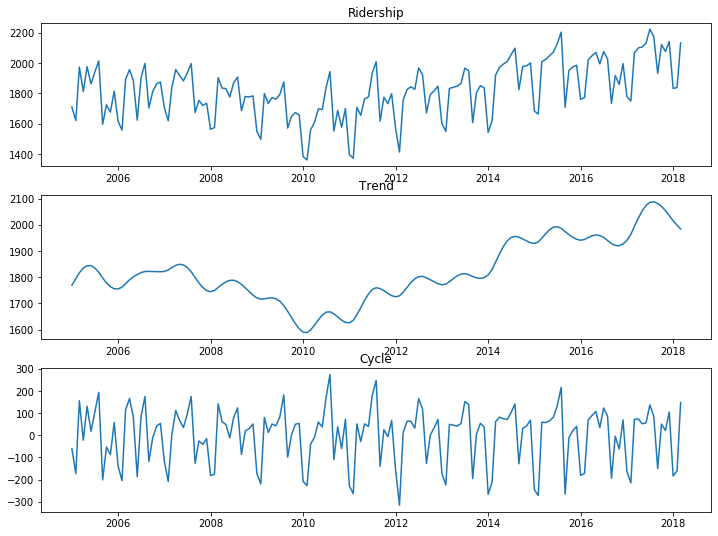

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
series = rider_ts['Ridership']
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Ridership')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

Test RMSE: 159.89251


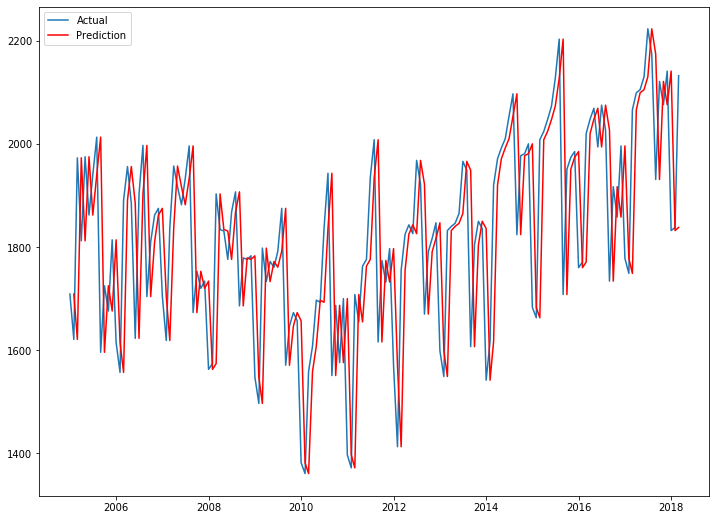

In [127]:
predictions = series.shift(1).dropna()
test_score = np.sqrt(mean_squared_error(series[int(len(series) -27)+1:], predictions.iloc[int(len(series) -27):]))
print('Test RMSE: %.5f' % test_score)
plt.plot(series, label='Actual')
plt.plot(predictions, color='red', label='Prediction')
plt.legend()
plt.show()

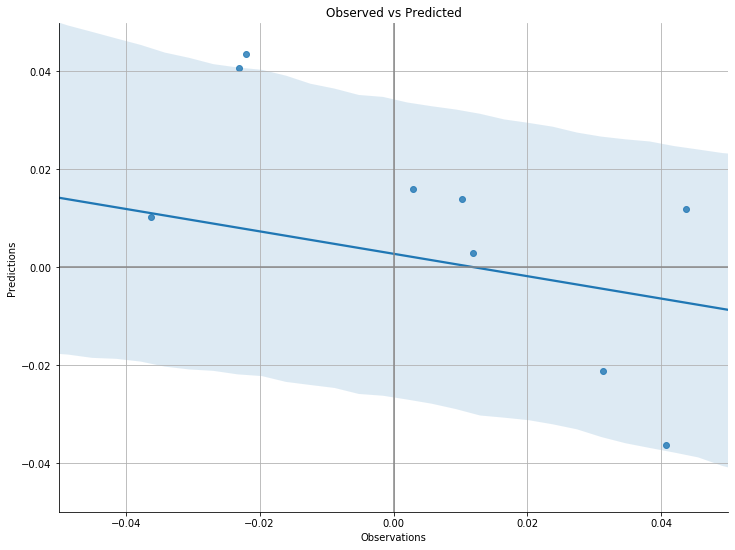

The MAE is 0.1113


In [129]:
fig, ax = plt.subplots()
ax = sns.regplot(series.iloc[-27:].pct_change(),
            predictions.iloc[-27:].pct_change(), )
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Observed vs Predicted')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(series.iloc[-27:].pct_change() - predictions.iloc[-27:].pct_change()).mean(),4)
print(f'The MAE is {mae}')

In [130]:
pred = pd.concat([series.iloc[-27:].pct_change(), predictions.iloc[-27:].pct_change()], axis=1)
pred.dropna(inplace=True)
pred.columns = ['Ridership', 'preds']
pred['hit'] = np.where(np.sign(pred['Ridership']) == np.sign(pred['preds']), 1, 0)
print(f"Hit rate: {round((pred['hit'].sum() / pred['hit'].count()) * 100,2)}%")

Hit rate: 42.31%


Test for trend MSE: 215.18219604175778


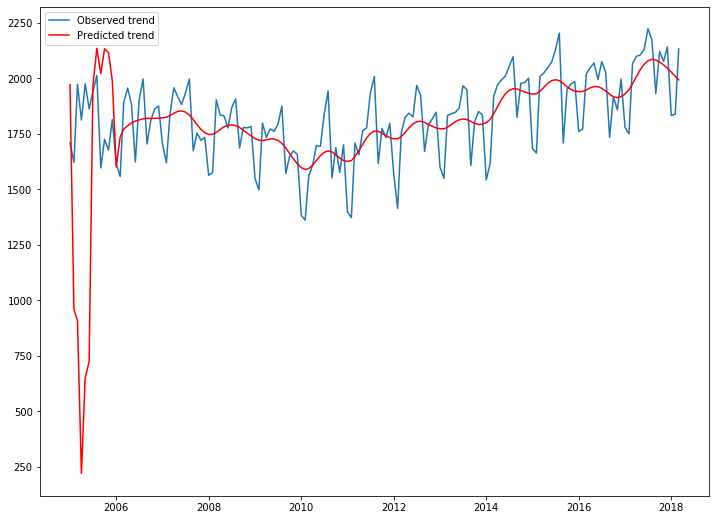

Test for cycle MSE: 57.421594123449715


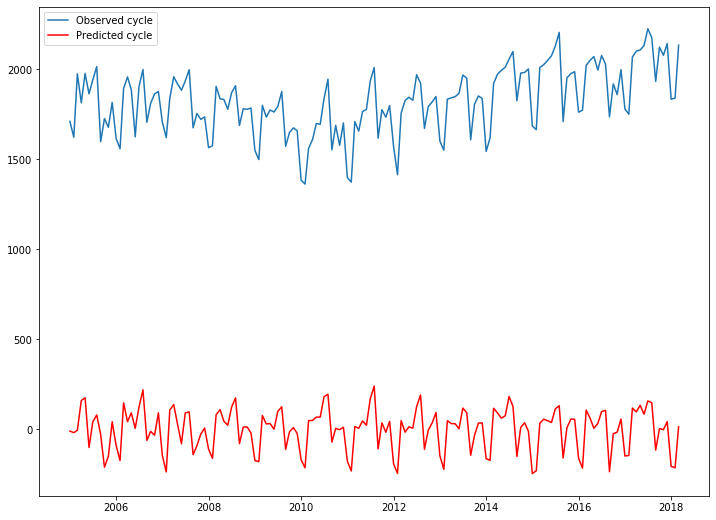

In [148]:
component_dict = {'cycle': cycle, 'trend': trend}
prediction_results = []
for component in ['trend', 'cycle']:
    historic = component_dict[component].iloc[:].to_list()
    test = component_dict[component].iloc[:]
    predictions = []
    for i in range(len(test)):
        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(series.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

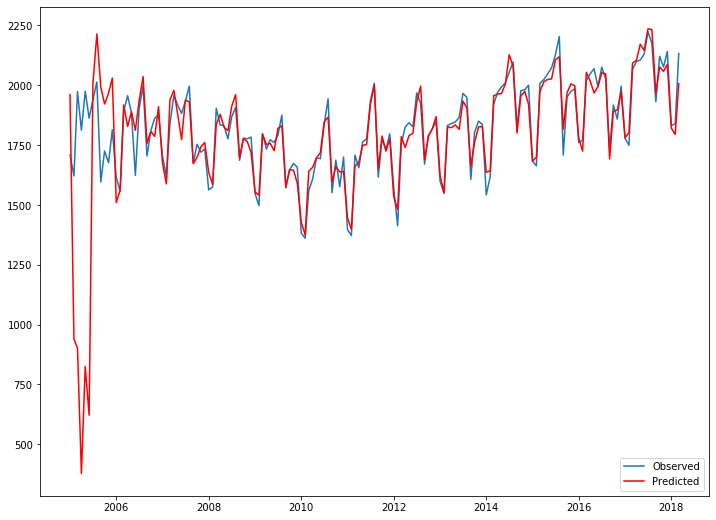

         Metrics
MAPE    0.043253
ME    -26.342171
MAE    78.546658
MPE    -0.012974
RMSE  214.166842
MSE: 1811.67458


In [150]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
recomposed_preds.name = 'recomposed_preds'
plt.plot(series.iloc[:], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(test, recomposed_preds))
forecast_accuracy(recomposed_preds, series.iloc[:])
print('MSE: %.5f' % test_score)

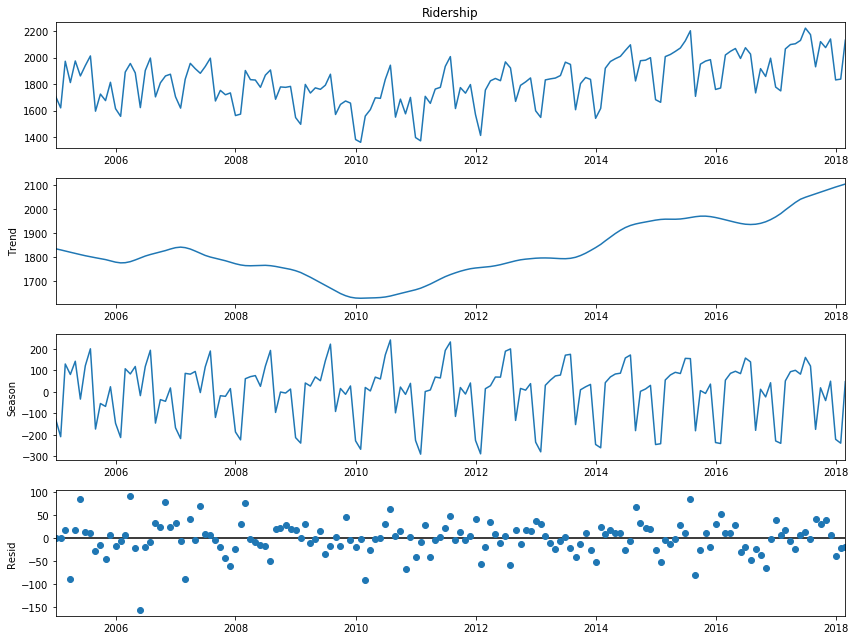

In [7]:
result = STL(series).fit()
result.plot()
plt.show()

          Metrics
MAPE     1.005651
ME   -1823.325212
MAE   1823.325212
MPE     -1.005651
RMSE  1828.974157
Test for seasonal MSE: 1828.9741574474367


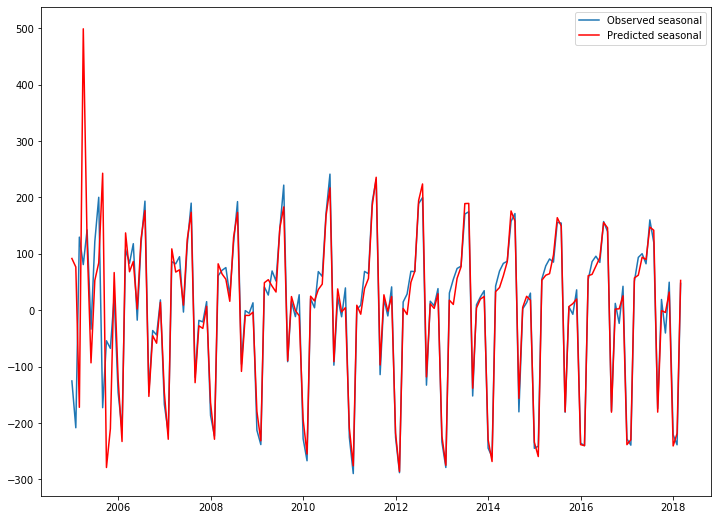

         Metrics
MAPE    0.134246
ME    -44.172294
MAE   233.675133
MPE    -0.015995
RMSE  748.841170
Test for trend MSE: 748.8411702071675


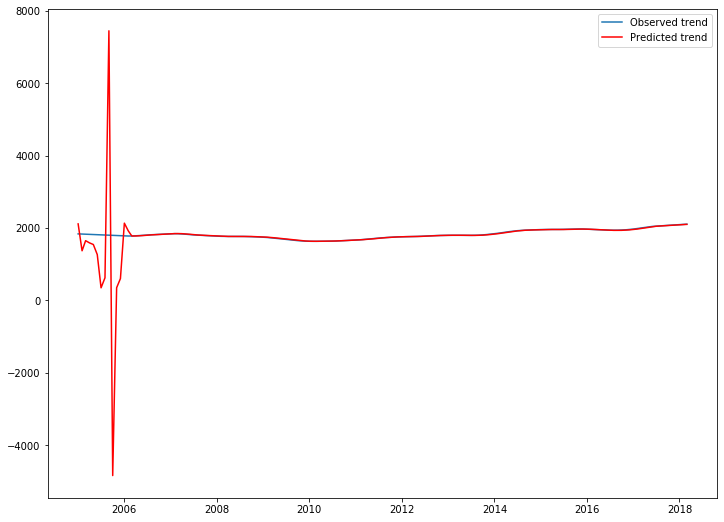

          Metrics
MAPE     1.000223
ME   -1822.490841
MAE   1822.490841
MPE     -1.000223
RMSE  1831.441652
Test for residual MSE: 1831.4416521778867


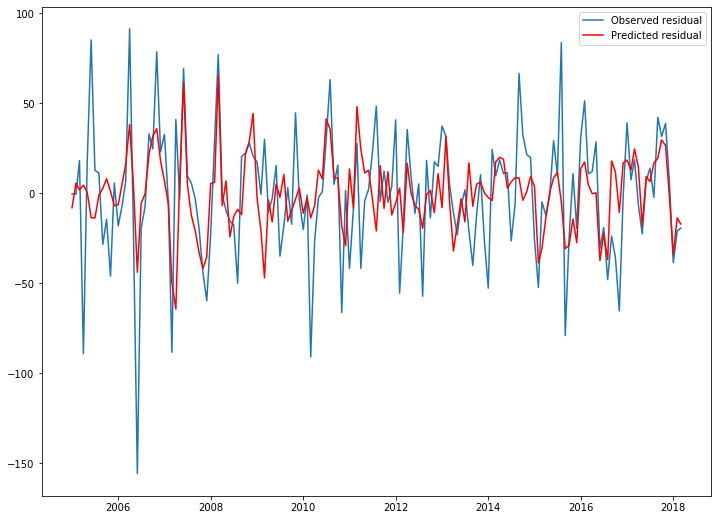

In [13]:
component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}
prediction_results = []
for component in ['seasonal', 'trend', 'residual']:
    historic = component_dict[component].iloc[:].to_list()
    test = component_dict[component].iloc[:]
    predictions = []
    for i in range(len(series)):
        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(series, predictions))
    forecast_accuracy(predictions, series.iloc[:])
    print(f'Test for {component} MSE: {test_score}')

    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()